# Anime Recommendation Training
Train embeddings for users and anime using PyTorch, with genre features and checkpointing.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import glob
import os
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
from dataset import RatingsPTDataset

## 1. Training parameters and paths

In [2]:
THRESHOLD = 500
EPOCHS = 20
CHECKPOINT_PATH = f"checkpoints/hybridLeaky{THRESHOLD}"
os.makedirs(CHECKPOINT_PATH, exist_ok=True)
CHECKPOINT_INTERVAL = 30_000
USERNAME = 'sirawesomeness'
# USERNAME = 'catfire8'

In [3]:
# Count total ratings

threshold_folder = f"data/pt_files{THRESHOLD}"
pattern = os.path.join(threshold_folder, f"user_anime????????????_filtered{THRESHOLD}.pt")
csv_files = glob.glob(pattern)

# anime_counter = Counter()
count = 0
for file_path in tqdm(csv_files):
    df = torch.load(file_path)
    count += len(df['anime_idx'])
    if not len(df):
        print(file_path)
print("TOTAL_RATINGS:", count)
print("THRESHOLD:",THRESHOLD)
TOTAL_RATINGS = count
BATCH_SIZE = 1024
TOTAL_BATCHES = TOTAL_RATINGS // BATCH_SIZE

100%|██████████| 70/70 [00:02<00:00, 24.67it/s]

TOTAL_RATINGS: 127102285
THRESHOLD: 500


## 2. Load anime data

In [4]:
anime_id_to_idx = torch.load(f"data/pt_files{THRESHOLD}/anime_id_to_idx.pt", weights_only=False)
anime_genres = torch.load(f"data/pt_files{THRESHOLD}/anime_genres.pt")

num_anime, num_genres = anime_genres.shape
print("NUMBER OF ANIMES:",num_anime)
print("NUMBER OF GENRES:",num_genres)

NUMBER OF ANIMES: 7448
NUMBER OF GENRES: 44


## 3. Map all users

In [5]:
user_id_to_idx = torch.load(f"data/pt_files{THRESHOLD}/user_id_to_idx.pt")
num_users = len(user_id_to_idx)

print("NUMBER OF USERS:", num_users)

NUMBER OF USERS: 977946


## 4. Custom Dataset

Load from dataset.py

## 5. Define embedding model

In [6]:
class HybridMF(nn.Module):
    def __init__(self, num_users, num_anime, num_genres, 
                 user_dim=64, anime_dim=128, genre_proj_dim=16, hidden_dim=32):
        super().__init__()
        self.user_emb = nn.Embedding(num_users, user_dim, sparse=True)
        self.anime_emb = nn.Embedding(num_anime, anime_dim, sparse=True)
        self.W_genre = nn.Linear(num_genres, genre_proj_dim)
        self.project = nn.Linear(anime_dim + genre_proj_dim, user_dim)
        
        # Nonlinear MLP
        self.mlp = nn.Sequential(
            nn.Linear(user_dim + anime_dim + genre_proj_dim, hidden_dim),
            nn.LeakyReLU(0.01),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, user_idx, anime_idx, anime_genres):
        u = self.user_emb(user_idx)
        v = self.anime_emb(anime_idx)
        g = self.W_genre(anime_genres[anime_idx])
        
        # ----- Linear path -----
        v_combined = torch.cat([v, g], dim=1)
        v_proj = self.project(v_combined)
        linear_pred = (u * v_proj).sum(dim=1)

        # ----- Nonlinear path -----
        mlp_input = torch.cat([u, v, g], dim=1)
        nonlinear_pred = self.mlp(mlp_input).squeeze(1)
        
        return linear_pred + nonlinear_pred
    
    def recommend(self, user_idx, anime_genres, top_k=10, device="cpu", exclude_ids=None):
        self.eval()
        with torch.no_grad():
            # Repeat user_idx across all anime
            user_tensor = torch.tensor([user_idx] * anime_genres.size(0), 
                                       dtype=torch.long, device=device)
            anime_tensor = torch.arange(anime_genres.size(0), 
                                        dtype=torch.long, device=device)
            
            preds = self.forward(user_tensor, anime_tensor, anime_genres)
            
            if exclude_ids is not None:
                preds[exclude_ids] = float("-inf")  # mask out watched anime

            # Get top-k indices
            top_scores, top_indices = torch.topk(preds, top_k)
        
        return top_indices.cpu().tolist(), top_scores.cpu().tolist()

## 6. Training setup

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = HybridMF(num_users, num_anime, num_genres).to(device)

sparse_params = list(model.user_emb.parameters()) + list(model.anime_emb.parameters())
dense_params = list(model.W_genre.parameters()) + list(model.project.parameters()) + list(model.mlp.parameters())

optimizer_sparse = optim.SparseAdam(sparse_params, lr=5e-3)
optimizer_dense = optim.Adam(dense_params, lr=1e-3, weight_decay=1e-5)
loss_fn = nn.MSELoss()

def save_checkpoint(model, optimizer_sparse, optimizer_dense, epoch, batch_in_epoch, loss, filename):
    torch.save({
        "epoch": epoch,
        "batch_in_epoch": batch_in_epoch,
        "model_state_dict": model.state_dict(),
        "optimizer_sparse_state_dict": optimizer_sparse.state_dict(),
        "optimizer_dense_state_dict": optimizer_dense.state_dict(),
        "loss": loss,
    }, filename)

def load_checkpoint(model, optimizer_sparse, optimizer_dense, filename, device):
    checkpoint = torch.load(filename, map_location=device)
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer_sparse.load_state_dict(checkpoint["optimizer_sparse_state_dict"])
    optimizer_dense.load_state_dict(checkpoint["optimizer_dense_state_dict"])
    start_epoch = checkpoint.get("epoch", 0)
    start_batch_in_epoch = checkpoint.get("batch_in_epoch", 0)
    loss = checkpoint["loss"]
    return start_epoch, start_batch_in_epoch, loss

pt_files = sorted(glob.glob(f"data/pt_files{THRESHOLD}/user_anime*_filtered{THRESHOLD}.pt"))
global_seed = random.randint(0, 2**32 - 1)
dataset = RatingsPTDataset(pt_files, global_seed)
loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, num_workers=4)
anime_genres = anime_genres.to(device)

## 7. Training loop

In [20]:
start_epoch, start_batch_in_epoch, prev_loss = 0, 0, None
checkpoint_files = sorted(glob.glob(os.path.join(CHECKPOINT_PATH, "epoch*.pth")))
if checkpoint_files:
    last_checkpoint = checkpoint_files[-1]
    start_epoch, start_batch_in_epoch, prev_loss = load_checkpoint(model, optimizer_sparse, optimizer_dense, last_checkpoint, device)
    print(f"Resuming from {last_checkpoint}, epoch={start_epoch}, batch_in_epoch={start_batch_in_epoch}, prev_loss={prev_loss:.4f}")
    
for epoch in range(start_epoch, EPOCHS):
    total_loss = 0
    count = 0
    
    checkpoint_loss = 0
    checkpoint_count = 0
    
    progress_bar = tqdm(loader, total=TOTAL_BATCHES, desc=f"Epoch {epoch+1}/{EPOCHS}")
    
    for i, batch in enumerate(progress_bar):
        if epoch == start_epoch and i < start_batch_in_epoch:
            continue
        
        user_idx_batch, anime_idx_batch, score_batch = batch
        user_idx_batch = user_idx_batch.to(device)
        anime_idx_batch = anime_idx_batch.to(device)
        score_batch = score_batch.to(device)

        optimizer_sparse.zero_grad()
        optimizer_dense.zero_grad()
        pred = model(user_idx_batch, anime_idx_batch, anime_genres)
        loss = loss_fn(pred, score_batch)
        loss.backward()
        optimizer_sparse.step()
        optimizer_dense.step()

        total_loss += loss.item() * len(user_idx_batch)
        count += len(user_idx_batch)
        
        checkpoint_loss += loss.item() * len(user_idx_batch)
        checkpoint_count += len(user_idx_batch)
        

        # periodic checkpoint
        if (i + 1) % CHECKPOINT_INTERVAL == 0:
            ckpt_path = os.path.join(CHECKPOINT_PATH, f"epoch{epoch+1:02d}.pth")
            save_checkpoint(model, optimizer_sparse, optimizer_dense, epoch, i + 1, total_loss / count, ckpt_path)
            progress_bar.write(f"💾 Saved checkpoint: {ckpt_path}, Checkpoint Loss: {checkpoint_loss / max(1, checkpoint_count)}")
            checkpoint_loss, checkpoint_count = 0, 0

    # end of epoch checkpoint
    ckpt_path = os.path.join(CHECKPOINT_PATH, f"epoch{epoch+1:02d}.pth")
    save_checkpoint(model, optimizer_sparse, optimizer_dense, epoch + 1, 0, total_loss / count, ckpt_path)
    progress_bar.write(f"💾 Saved checkpoint: {ckpt_path}, Epoch Loss: {total_loss / count}")

Epoch 1/20:  24%|██▍       | 30011/124123 [04:12<13:44:36,  1.90it/s]

💾 Saved checkpoint: checkpoints/hybridLeaky500\epoch01.pth, Checkpoint Loss: 2.121038082075119


Epoch 1/20:  48%|████▊     | 60026/124123 [07:51<21:21, 50.02it/s]   

💾 Saved checkpoint: checkpoints/hybridLeaky500\epoch01.pth, Checkpoint Loss: 0.8773871775984764


Epoch 1/20:  73%|███████▎  | 90030/124123 [11:51<13:35, 41.81it/s] 

💾 Saved checkpoint: checkpoints/hybridLeaky500\epoch01.pth, Checkpoint Loss: 0.5694004315018654


Epoch 1/20:  97%|█████████▋| 120035/124123 [15:54<01:15, 54.01it/s] 

💾 Saved checkpoint: checkpoints/hybridLeaky500\epoch01.pth, Checkpoint Loss: 0.42451205791491725


Epoch 1/20: 124125it [16:33, 124.90it/s]                            


💾 Saved checkpoint: checkpoints/hybridLeaky500\epoch01.pth, Epoch Loss: 1.815202907993885


Epoch 2/20:  24%|██▍       | 30023/124123 [04:05<35:58, 43.60it/s]  

💾 Saved checkpoint: checkpoints/hybridLeaky500\epoch02.pth, Checkpoint Loss: 1.5948730861902236


Epoch 2/20:  48%|████▊     | 60023/124123 [08:09<26:29, 40.33it/s] 

💾 Saved checkpoint: checkpoints/hybridLeaky500\epoch02.pth, Checkpoint Loss: 0.7754681023597717


Epoch 2/20:  73%|███████▎  | 90022/124123 [12:07<13:31, 42.02it/s] 

💾 Saved checkpoint: checkpoints/hybridLeaky500\epoch02.pth, Checkpoint Loss: 0.5095352470821805


Epoch 2/20:  97%|█████████▋| 120020/124123 [16:06<02:08, 31.81it/s] 

💾 Saved checkpoint: checkpoints/hybridLeaky500\epoch02.pth, Checkpoint Loss: 0.38048711279193964


Epoch 2/20: 124125it [16:45, 123.41it/s]                            


💾 Saved checkpoint: checkpoints/hybridLeaky500\epoch02.pth, Epoch Loss: 1.5484415406605485


Epoch 3/20:  24%|██▍       | 30018/124123 [04:05<35:29, 44.18it/s]  

💾 Saved checkpoint: checkpoints/hybridLeaky500\epoch03.pth, Checkpoint Loss: 1.5256127020557722


Epoch 3/20:  48%|████▊     | 60023/124123 [08:08<28:53, 36.99it/s] 

💾 Saved checkpoint: checkpoints/hybridLeaky500\epoch03.pth, Checkpoint Loss: 0.7474536176284154


Epoch 3/20:  73%|███████▎  | 90015/124123 [12:11<14:06, 40.31it/s] 

💾 Saved checkpoint: checkpoints/hybridLeaky500\epoch03.pth, Checkpoint Loss: 0.4924450312455495


Epoch 3/20:  97%|█████████▋| 120019/124123 [16:18<01:54, 35.99it/s] 

💾 Saved checkpoint: checkpoints/hybridLeaky500\epoch03.pth, Checkpoint Loss: 0.3684336817614355


Epoch 3/20: 124125it [16:57, 121.96it/s]                            


💾 Saved checkpoint: checkpoints/hybridLeaky500\epoch03.pth, Epoch Loss: 1.492642364760026


Epoch 4/20:  24%|██▍       | 30022/124123 [04:04<1:15:37, 20.74it/s]

💾 Saved checkpoint: checkpoints/hybridLeaky500\epoch04.pth, Checkpoint Loss: 1.4824272539536159


Epoch 4/20:  48%|████▊     | 60017/124123 [08:10<1:06:23, 16.09it/s]

💾 Saved checkpoint: checkpoints/hybridLeaky500\epoch04.pth, Checkpoint Loss: 0.7298756522496541


Epoch 4/20:  73%|███████▎  | 90018/124123 [12:15<26:35, 21.38it/s]  

💾 Saved checkpoint: checkpoints/hybridLeaky500\epoch04.pth, Checkpoint Loss: 0.4817437856886122


Epoch 4/20:  97%|█████████▋| 120018/124123 [16:20<02:38, 25.90it/s] 

💾 Saved checkpoint: checkpoints/hybridLeaky500\epoch04.pth, Checkpoint Loss: 0.3618941535570262


Epoch 4/20: 124125it [17:00, 121.66it/s]                            


💾 Saved checkpoint: checkpoints/hybridLeaky500\epoch04.pth, Epoch Loss: 1.4586822241473913


Epoch 5/20:  24%|██▍       | 30025/124123 [04:07<34:07, 45.95it/s]  

💾 Saved checkpoint: checkpoints/hybridLeaky500\epoch05.pth, Checkpoint Loss: 1.4495262987494468


Epoch 5/20:  48%|████▊     | 60017/124123 [08:04<27:01, 39.53it/s] 

💾 Saved checkpoint: checkpoints/hybridLeaky500\epoch05.pth, Checkpoint Loss: 0.7157556999425093


Epoch 5/20:  73%|███████▎  | 90022/124123 [12:03<13:40, 41.58it/s] 

💾 Saved checkpoint: checkpoints/hybridLeaky500\epoch05.pth, Checkpoint Loss: 0.47367335498862795


Epoch 5/20:  97%|█████████▋| 120017/124123 [16:17<02:18, 29.72it/s] 

💾 Saved checkpoint: checkpoints/hybridLeaky500\epoch05.pth, Checkpoint Loss: 0.35552854426009817


Epoch 5/20: 124125it [17:08, 120.74it/s]                            


💾 Saved checkpoint: checkpoints/hybridLeaky500\epoch05.pth, Epoch Loss: 1.4310885366010708


Epoch 6/20:  24%|██▍       | 30014/124123 [04:55<48:12, 32.54it/s]  

💾 Saved checkpoint: checkpoints/hybridLeaky500\epoch06.pth, Checkpoint Loss: 1.4236883984208106


Epoch 6/20:  48%|████▊     | 60011/124123 [09:24<52:28, 20.36it/s]  

💾 Saved checkpoint: checkpoints/hybridLeaky500\epoch06.pth, Checkpoint Loss: 0.7036819682935873


Epoch 6/20:  73%|███████▎  | 90018/124123 [14:02<1:38:55,  5.75it/s]

💾 Saved checkpoint: checkpoints/hybridLeaky500\epoch06.pth, Checkpoint Loss: 0.46644466001987456


Epoch 6/20:  97%|█████████▋| 120014/124123 [17:55<01:38, 41.85it/s] 

💾 Saved checkpoint: checkpoints/hybridLeaky500\epoch06.pth, Checkpoint Loss: 0.35026865651318023


Epoch 6/20: 124125it [18:32, 111.59it/s]                            


💾 Saved checkpoint: checkpoints/hybridLeaky500\epoch06.pth, Epoch Loss: 1.4081129356768685


Epoch 7/20:  24%|██▍       | 30023/124123 [04:19<29:34, 53.03it/s]  

💾 Saved checkpoint: checkpoints/hybridLeaky500\epoch07.pth, Checkpoint Loss: 1.4018473856608074


Epoch 7/20:  48%|████▊     | 60020/124123 [08:09<48:37, 21.98it/s]  

💾 Saved checkpoint: checkpoints/hybridLeaky500\epoch07.pth, Checkpoint Loss: 0.6922092334290345


Epoch 7/20:  73%|███████▎  | 90020/124123 [12:27<37:49, 15.03it/s] 

💾 Saved checkpoint: checkpoints/hybridLeaky500\epoch07.pth, Checkpoint Loss: 0.4595767729971144


Epoch 7/20:  97%|█████████▋| 120015/124123 [16:52<04:49, 14.19it/s] 

💾 Saved checkpoint: checkpoints/hybridLeaky500\epoch07.pth, Checkpoint Loss: 0.34514995647310936


Epoch 7/20: 124125it [17:33, 117.83it/s]                            


💾 Saved checkpoint: checkpoints/hybridLeaky500\epoch07.pth, Epoch Loss: 1.3865852641315848


Epoch 8/20:  24%|██▍       | 30022/124123 [04:04<36:37, 42.83it/s] 

💾 Saved checkpoint: checkpoints/hybridLeaky500\epoch08.pth, Checkpoint Loss: 1.3812519652803739


Epoch 8/20:  48%|████▊     | 60019/124123 [08:07<34:36, 30.87it/s] 

💾 Saved checkpoint: checkpoints/hybridLeaky500\epoch08.pth, Checkpoint Loss: 0.6818319576760133


Epoch 8/20:  73%|███████▎  | 90021/124123 [12:09<17:33, 32.37it/s] 

💾 Saved checkpoint: checkpoints/hybridLeaky500\epoch08.pth, Checkpoint Loss: 0.4534090412735939


Epoch 8/20:  97%|█████████▋| 120010/124123 [16:20<08:58,  7.64it/s] 

💾 Saved checkpoint: checkpoints/hybridLeaky500\epoch08.pth, Checkpoint Loss: 0.34101817714426946


Epoch 8/20: 124125it [16:59, 121.76it/s]                            


💾 Saved checkpoint: checkpoints/hybridLeaky500\epoch08.pth, Epoch Loss: 1.3674804710342987


Epoch 9/20:  24%|██▍       | 30036/124123 [04:06<27:35, 56.84it/s]  

💾 Saved checkpoint: checkpoints/hybridLeaky500\epoch09.pth, Checkpoint Loss: 1.3616781034708023


Epoch 9/20:  48%|████▊     | 60022/124123 [08:06<27:34, 38.74it/s] 

💾 Saved checkpoint: checkpoints/hybridLeaky500\epoch09.pth, Checkpoint Loss: 0.6716300069133441


Epoch 9/20:  73%|███████▎  | 90021/124123 [12:08<17:29, 32.50it/s] 

💾 Saved checkpoint: checkpoints/hybridLeaky500\epoch09.pth, Checkpoint Loss: 0.4473047083232138


Epoch 9/20:  97%|█████████▋| 120020/124123 [15:52<02:28, 27.61it/s] 

💾 Saved checkpoint: checkpoints/hybridLeaky500\epoch09.pth, Checkpoint Loss: 0.3363275618153572


Epoch 9/20: 124125it [16:38, 124.35it/s]                            


💾 Saved checkpoint: checkpoints/hybridLeaky500\epoch09.pth, Epoch Loss: 1.3482620486744172


Epoch 10/20:  24%|██▍       | 30038/124123 [03:18<27:50, 56.34it/s] 

💾 Saved checkpoint: checkpoints/hybridLeaky500\epoch10.pth, Checkpoint Loss: 1.3432302970846495


Epoch 10/20:  48%|████▊     | 60023/124123 [06:39<21:53, 48.82it/s] 

💾 Saved checkpoint: checkpoints/hybridLeaky500\epoch10.pth, Checkpoint Loss: 0.6619669557690621


Epoch 10/20:  73%|███████▎  | 90025/124123 [09:39<11:09, 50.94it/s] 

💾 Saved checkpoint: checkpoints/hybridLeaky500\epoch10.pth, Checkpoint Loss: 0.4414702611313926


Epoch 10/20:  97%|█████████▋| 120020/124123 [12:53<01:57, 34.84it/s] 

💾 Saved checkpoint: checkpoints/hybridLeaky500\epoch10.pth, Checkpoint Loss: 0.3320347181814674


Epoch 10/20: 124125it [13:39, 151.51it/s]                            


💾 Saved checkpoint: checkpoints/hybridLeaky500\epoch10.pth, Epoch Loss: 1.3301759471311703


Epoch 11/20:  24%|██▍       | 30013/124123 [03:30<5:37:24,  4.65it/s]

💾 Saved checkpoint: checkpoints/hybridLeaky500\epoch11.pth, Checkpoint Loss: 1.325412253298362


Epoch 11/20:  48%|████▊     | 60010/124123 [07:19<7:32:45,  2.36it/s] 

💾 Saved checkpoint: checkpoints/hybridLeaky500\epoch11.pth, Checkpoint Loss: 0.6527967255353928


Epoch 11/20:  73%|███████▎  | 90024/124123 [10:56<1:05:13,  8.71it/s]

💾 Saved checkpoint: checkpoints/hybridLeaky500\epoch11.pth, Checkpoint Loss: 0.435838625262181


Epoch 11/20:  97%|█████████▋| 120013/124123 [14:14<11:07,  6.15it/s] 

💾 Saved checkpoint: checkpoints/hybridLeaky500\epoch11.pth, Checkpoint Loss: 0.32829130412669566


Epoch 11/20: 124125it [14:50, 139.41it/s]                            


💾 Saved checkpoint: checkpoints/hybridLeaky500\epoch11.pth, Epoch Loss: 1.3131874661148566


Epoch 12/20:  24%|██▍       | 30026/124123 [03:25<57:41, 27.18it/s]  

💾 Saved checkpoint: checkpoints/hybridLeaky500\epoch12.pth, Checkpoint Loss: 1.3083294511318206


Epoch 12/20:  48%|████▊     | 60034/124123 [06:50<27:05, 39.43it/s] 

💾 Saved checkpoint: checkpoints/hybridLeaky500\epoch12.pth, Checkpoint Loss: 0.6441919106105963


Epoch 12/20:  73%|███████▎  | 90021/124123 [09:55<20:14, 28.07it/s] 

💾 Saved checkpoint: checkpoints/hybridLeaky500\epoch12.pth, Checkpoint Loss: 0.4304301059808996


Epoch 12/20:  97%|█████████▋| 120020/124123 [13:13<02:20, 29.25it/s] 

💾 Saved checkpoint: checkpoints/hybridLeaky500\epoch12.pth, Checkpoint Loss: 0.32422256835989355


Epoch 12/20: 124125it [13:48, 149.78it/s]                            


💾 Saved checkpoint: checkpoints/hybridLeaky500\epoch12.pth, Epoch Loss: 1.2965206121277075


Epoch 13/20:  24%|██▍       | 30023/124123 [03:10<1:50:48, 14.15it/s]

💾 Saved checkpoint: checkpoints/hybridLeaky500\epoch13.pth, Checkpoint Loss: 1.292164457823833


Epoch 13/20:  48%|████▊     | 60026/124123 [06:20<1:28:30, 12.07it/s]

💾 Saved checkpoint: checkpoints/hybridLeaky500\epoch13.pth, Checkpoint Loss: 0.6360676641762256


Epoch 13/20:  73%|███████▎  | 90020/124123 [09:38<16:35, 34.24it/s]  

💾 Saved checkpoint: checkpoints/hybridLeaky500\epoch13.pth, Checkpoint Loss: 0.4252316957977083


Epoch 13/20:  97%|█████████▋| 120028/124123 [12:46<01:52, 36.24it/s] 

💾 Saved checkpoint: checkpoints/hybridLeaky500\epoch13.pth, Checkpoint Loss: 0.32065636457687713


Epoch 13/20: 124125it [13:17, 155.60it/s]                            


💾 Saved checkpoint: checkpoints/hybridLeaky500\epoch13.pth, Epoch Loss: 1.2809777640670637


Epoch 14/20:  24%|██▍       | 30027/124123 [03:44<39:40, 39.54it/s] 

💾 Saved checkpoint: checkpoints/hybridLeaky500\epoch14.pth, Checkpoint Loss: 1.2764701324701309


Epoch 14/20:  48%|████▊     | 60013/124123 [07:07<1:09:49, 15.30it/s]

💾 Saved checkpoint: checkpoints/hybridLeaky500\epoch14.pth, Checkpoint Loss: 0.6284096421758334


Epoch 14/20:  73%|███████▎  | 90022/124123 [10:53<28:10, 20.18it/s]  

💾 Saved checkpoint: checkpoints/hybridLeaky500\epoch14.pth, Checkpoint Loss: 0.4202591179211934


Epoch 14/20:  97%|█████████▋| 120014/124123 [15:47<04:09, 16.45it/s] 

💾 Saved checkpoint: checkpoints/hybridLeaky500\epoch14.pth, Checkpoint Loss: 0.3170605818755001


Epoch 14/20: 124125it [16:37, 124.46it/s]                            


💾 Saved checkpoint: checkpoints/hybridLeaky500\epoch14.pth, Epoch Loss: 1.2659227264712216


Epoch 15/20:  24%|██▍       | 30024/124123 [03:45<35:05, 44.68it/s] 

💾 Saved checkpoint: checkpoints/hybridLeaky500\epoch15.pth, Checkpoint Loss: 1.2615683825910091


Epoch 15/20:  48%|████▊     | 60023/124123 [07:45<34:20, 31.10it/s] 

💾 Saved checkpoint: checkpoints/hybridLeaky500\epoch15.pth, Checkpoint Loss: 0.6211287460337083


Epoch 15/20:  73%|███████▎  | 90014/124123 [11:56<16:39, 34.13it/s] 

💾 Saved checkpoint: checkpoints/hybridLeaky500\epoch15.pth, Checkpoint Loss: 0.41548383899860913


Epoch 15/20:  97%|█████████▋| 120019/124123 [15:41<02:04, 32.97it/s] 

💾 Saved checkpoint: checkpoints/hybridLeaky500\epoch15.pth, Checkpoint Loss: 0.31378748879468465


Epoch 15/20: 124125it [16:24, 126.04it/s]                            


💾 Saved checkpoint: checkpoints/hybridLeaky500\epoch15.pth, Epoch Loss: 1.2517146118353457


Epoch 16/20:  24%|██▍       | 30023/124123 [03:28<45:11, 34.71it/s] 

💾 Saved checkpoint: checkpoints/hybridLeaky500\epoch16.pth, Checkpoint Loss: 1.2474635897795359


Epoch 16/20:  48%|████▊     | 60016/124123 [07:51<29:49, 35.82it/s] 

💾 Saved checkpoint: checkpoints/hybridLeaky500\epoch16.pth, Checkpoint Loss: 0.6142972021271785


Epoch 16/20:  73%|███████▎  | 90013/124123 [12:27<2:18:07,  4.12it/s]

💾 Saved checkpoint: checkpoints/hybridLeaky500\epoch16.pth, Checkpoint Loss: 0.4109410500122441


Epoch 16/20:  97%|█████████▋| 120023/124123 [16:45<01:55, 35.55it/s] 

💾 Saved checkpoint: checkpoints/hybridLeaky500\epoch16.pth, Checkpoint Loss: 0.3104043865355749


Epoch 16/20: 124125it [17:29, 118.32it/s]                            


💾 Saved checkpoint: checkpoints/hybridLeaky500\epoch16.pth, Epoch Loss: 1.2379895405628247


Epoch 17/20:  24%|██▍       | 30022/124123 [04:33<40:17, 38.93it/s]  

💾 Saved checkpoint: checkpoints/hybridLeaky500\epoch17.pth, Checkpoint Loss: 1.2338850727717081


Epoch 17/20:  48%|████▊     | 60015/124123 [09:03<33:34, 31.83it/s]  

💾 Saved checkpoint: checkpoints/hybridLeaky500\epoch17.pth, Checkpoint Loss: 0.6076885637034972


Epoch 17/20:  73%|███████▎  | 90018/124123 [13:31<16:34, 34.28it/s] 

💾 Saved checkpoint: checkpoints/hybridLeaky500\epoch17.pth, Checkpoint Loss: 0.4065571690062682


Epoch 17/20:  97%|█████████▋| 120019/124123 [18:00<02:03, 33.31it/s] 

💾 Saved checkpoint: checkpoints/hybridLeaky500\epoch17.pth, Checkpoint Loss: 0.30738411336832716


Epoch 17/20: 124125it [18:44, 110.37it/s]                            


💾 Saved checkpoint: checkpoints/hybridLeaky500\epoch17.pth, Epoch Loss: 1.224984662326541


Epoch 18/20:  24%|██▍       | 30018/124123 [04:18<48:25, 32.39it/s]  

💾 Saved checkpoint: checkpoints/hybridLeaky500\epoch18.pth, Checkpoint Loss: 1.2207995962878069


Epoch 18/20:  48%|████▊     | 60016/124123 [08:33<30:34, 34.94it/s] 

💾 Saved checkpoint: checkpoints/hybridLeaky500\epoch18.pth, Checkpoint Loss: 0.6014176821867625


Epoch 18/20:  73%|███████▎  | 90015/124123 [13:22<2:16:02,  4.18it/s]

💾 Saved checkpoint: checkpoints/hybridLeaky500\epoch18.pth, Checkpoint Loss: 0.40235515060491034


Epoch 18/20:  97%|█████████▋| 120009/124123 [18:07<11:41,  5.86it/s] 

💾 Saved checkpoint: checkpoints/hybridLeaky500\epoch18.pth, Checkpoint Loss: 0.3041827501494576


Epoch 18/20: 124125it [18:55, 109.34it/s]                            


💾 Saved checkpoint: checkpoints/hybridLeaky500\epoch18.pth, Epoch Loss: 1.2122313470650299


Epoch 19/20:  24%|██▍       | 30021/124123 [04:38<52:17, 29.99it/s]  

💾 Saved checkpoint: checkpoints/hybridLeaky500\epoch19.pth, Checkpoint Loss: 1.2081612253765266


Epoch 19/20:  48%|████▊     | 60022/124123 [09:20<34:44, 30.76it/s] 

💾 Saved checkpoint: checkpoints/hybridLeaky500\epoch19.pth, Checkpoint Loss: 0.5953958210666974


Epoch 19/20:  73%|███████▎  | 90018/124123 [13:56<17:44, 32.03it/s] 

💾 Saved checkpoint: checkpoints/hybridLeaky500\epoch19.pth, Checkpoint Loss: 0.39835163061883716


Epoch 19/20:  97%|█████████▋| 120019/124123 [18:37<01:54, 35.78it/s] 

💾 Saved checkpoint: checkpoints/hybridLeaky500\epoch19.pth, Checkpoint Loss: 0.30151992742452854


Epoch 19/20: 124125it [19:23, 106.64it/s]                            


💾 Saved checkpoint: checkpoints/hybridLeaky500\epoch19.pth, Epoch Loss: 1.2003923909195855


Epoch 20/20:  24%|██▍       | 30017/124123 [04:27<53:16, 29.44it/s]  

💾 Saved checkpoint: checkpoints/hybridLeaky500\epoch20.pth, Checkpoint Loss: 1.196174887361129


Epoch 20/20:  48%|████▊     | 60029/124123 [09:55<4:44:26,  3.76it/s]

💾 Saved checkpoint: checkpoints/hybridLeaky500\epoch20.pth, Checkpoint Loss: 0.5896444570889076


Epoch 20/20:  73%|███████▎  | 90018/124123 [12:56<13:46, 41.29it/s]  

💾 Saved checkpoint: checkpoints/hybridLeaky500\epoch20.pth, Checkpoint Loss: 0.394463497231404


Epoch 20/20:  97%|█████████▋| 120021/124123 [16:25<01:32, 44.54it/s] 

💾 Saved checkpoint: checkpoints/hybridLeaky500\epoch20.pth, Checkpoint Loss: 0.29861946074740114


Epoch 20/20: 124125it [17:02, 121.45it/s]                            


💾 Saved checkpoint: checkpoints/hybridLeaky500\epoch20.pth, Epoch Loss: 1.1887345090754036


## 8. Make Recommendations


In [23]:
# Get watched animes

filtered_folder = f"data/pt_files{THRESHOLD}"
pattern = os.path.join(filtered_folder, f"user_anime????????????_filtered{THRESHOLD}.pt")
pt_files = glob.glob(pattern)
user_idx = int(user_id_to_idx[USERNAME]) # convert to Python int
anime_indices_list = []
scores = []

for file in tqdm(pt_files):
    data = torch.load(file, map_location='cpu')  # dict of tensors

    # Boolean mask for rows of this user
    mask = data['user_idx'] == user_idx

    # Extract anime indices for this user
    user_animes = data['anime_idx'][mask]
    user_scores = data['scores'][mask]

    if user_animes.numel() > 0:
        anime_indices_list.extend(user_animes)
        scores.extend(user_scores)
        
anime_path = "data/filteredRatings/anime_filtered.csv" if not THRESHOLD else f"data/filteredRatingsThreshold{THRESHOLD}/anime_filtered.csv"
df = pd.read_csv(anime_path)
df = df.iloc[anime_indices_list]
print(f"Anime {USERNAME} rated 10 to verify")
for title,score in zip(df['title'],scores):
    score = int(score)
    if score == 10:
        print(score, title)


100%|██████████| 70/70 [00:06<00:00, 11.38it/s]


Anime sirawesomeness rated 10 to verify
10 Naruto: Shippuuden
10 Naruto
10 Fate/stay night Movie: Heaven's Feel - I. Presage Flower
10 JoJo no Kimyou na Bouken Part 3: Stardust Crusaders 2nd Season
10 Fate/stay night: Unlimited Blade Works 2nd Season
10 Koe no Katachi
10 Gintama°
10 Code Geass: Hangyaku no Lelouch R2
10 Re:Zero kara Hajimeru Isekai Seikatsu
10 Fate/stay night Movie: Heaven's Feel - II. Lost Butterfly
10 Fate/stay night Movie: Heaven's Feel - III. Spring Song
10 Haikyuu!! Movie 4: Concept no Tatakai
10 Boku no Hero Academia 4th Season
10 Mushoku Tensei: Isekai Ittara Honki Dasu
10 Re:Zero kara Hajimeru Isekai Seikatsu 2nd Season
10 Shokugeki no Souma: Shin no Sara
10 Shingeki no Kyojin: The Final Season
10 BNA
10 Haikyuu!! To the Top 2nd Season
10 Shokugeki no Souma: Gou no Sara
10 Mushoku Tensei: Isekai Ittara Honki Dasu Part 2
10 Odd Taxi


In [24]:
checkpoint_files = sorted(glob.glob(os.path.join(CHECKPOINT_PATH, "epoch*.pth")))
if checkpoint_files:
    last_checkpoint = checkpoint_files[-1]
    _, _, loss = load_checkpoint(model, optimizer_sparse, optimizer_dense, last_checkpoint, device)
    print(f"Making prediction from {last_checkpoint}, loss={loss:.4f}")

user_idx = user_id_to_idx[USERNAME]
# top_indices, top_scores = model.recommend(user_idx, anime_genres, device=device)
top_indices, top_scores = model.recommend(user_idx, anime_genres, device=device,exclude_ids=anime_indices_list)
anime_path = "data/filteredRatings/anime_filtered.csv" if not THRESHOLD else f"data/filteredRatingsThreshold{THRESHOLD}/anime_filtered.csv"
df = pd.read_csv(anime_path)
df = df.iloc[top_indices]
print(f"Recommendations for {USERNAME}")

# Calculate dynamic padding based on the longest title
max_title_len = df['title'].map(len).max()
title_col_width = max(max_title_len, len("Title")) + 2  # +2 for a little breathing room

# Print formatted header
print(f"{'Index':<6}  {'Title':<{title_col_width}}  {'URL'}")
print("-" * (title_col_width + 40))  # Adjust line length for aesthetics

# Print rows with dynamic spacing
index = 1
for _, row in df.iterrows():
    url = f"https://myanimelist.net/anime/{row['anime_id']}"
    print(f"{index:<6}  {row['title']:<{title_col_width}}  {url}")
    index += 1




Making prediction from checkpoints/hybridLeaky500\epoch20.pth, loss=1.1887
Recommendations for sirawesomeness
Index   Title                                       URL
----------------------------------------------------------------------------------
1       Nana                                        https://myanimelist.net/anime/877
2       Lupin III: Otakara Henkyaku Daisakusen!!    https://myanimelist.net/anime/1424
3       Ginga Eiyuu Densetsu                        https://myanimelist.net/anime/820
4       Gallery Fake                                https://myanimelist.net/anime/364
5       Uchuu Kyoudai                               https://myanimelist.net/anime/12431
6       Cross Game                                  https://myanimelist.net/anime/5941
7       Ashita no Joe 2                             https://myanimelist.net/anime/2921
8       Major S2                                    https://myanimelist.net/anime/558
9       Tsurikichi Sanpei                           https:

### Plot Loss

In [21]:
def load_checkpoint_loss(filename):
    checkpoint = torch.load(filename)
    start_epoch = checkpoint.get("epoch", 0)
    loss = checkpoint["loss"]
    return start_epoch, loss

def plot_losses(folder_path, pattern="*.pth"):
    model_name = os.path.basename(os.path.normpath(folder_path))
    # 1. Collect all checkpoint file paths
    files = sorted(glob.glob(f"{folder_path}/{pattern}"))

    if not files:
        print(f"No files found in {folder_path} with pattern {pattern}")
        return

    # 2. Load epochs and losses
    epochs, losses = [], []
    for f in files:
        try:
            epoch, loss = load_checkpoint_loss(f)
            epochs.append(epoch)
            losses.append(loss)
        except Exception as e:
            print(f"Skipping {f}: {e}")

    # 3. Sort by epoch (in case filenames aren't ordered)
    epochs, losses = zip(*sorted(zip(epochs, losses)))

    # 4. Plot
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, losses, marker='o')
    plt.title(f"Training Loss - {model_name.title()}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.show()

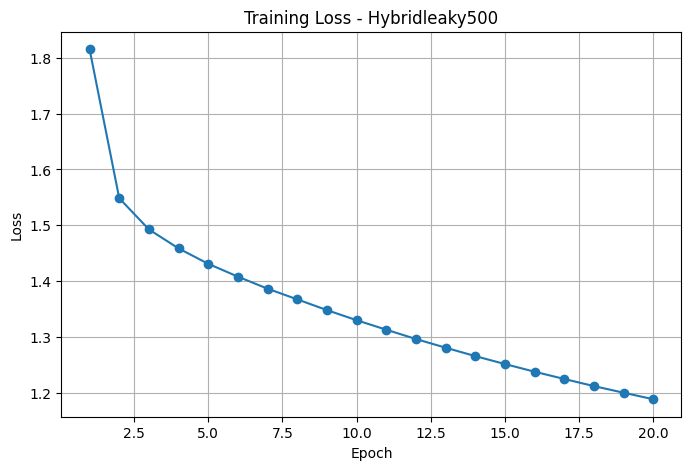

In [22]:
plot_losses("checkpoints/hybridLeaky500")

### Check Zeros ReLU

In [ ]:
def small_activation_hook(name, stats_dict):
    def hook(module, input, output):
        # Compute how many activations are "small" in magnitude
        small = (output.abs() < 1e-3).sum().item()
        total = output.numel()
        stats_dict[name] = {
            "small_count": small,
            "total_count": total,
            "small_fraction": small / total,
            "threshold": 1e-3
        }
    return hook

def check_dead_neurons(model, user_idx_batch, anime_idx_batch, anime_genres, device):
    activation_stats = {}

    # Register hooks on all ReLU layers
    hooks = []
    for name, module in model.named_modules():
        if isinstance(module, nn.LeakyReLU):
            hooks.append(module.register_forward_hook(small_activation_hook(name, activation_stats)))

    model.eval()
    with torch.no_grad():
        user_idx_batch = user_idx_batch.to(device)
        anime_idx_batch = anime_idx_batch.to(device)
        anime_genres = anime_genres.to(device)
        _ = model(user_idx_batch, anime_idx_batch, anime_genres)

    # Remove hooks
    for h in hooks:
        h.remove()

    return activation_stats

BATCH_SIZE_CHECK = 32
sample_data = torch.load(pt_files[0], map_location='cpu')
user_idx_batch = torch.tensor(sample_data["user_idx"][:BATCH_SIZE_CHECK])
anime_idx_batch = torch.tensor(sample_data["anime_idx"][:BATCH_SIZE_CHECK])

# Loop over all checkpoints
checkpoint_files = sorted(glob.glob(os.path.join(CHECKPOINT_PATH, "epoch*.pth")))

print("\Small Activation LeakyReLU neuron fraction per checkpoint:")
print("Epoch | % Small Activations")
print("----------------------")
for ckpt_file in checkpoint_files:
    epoch = int(os.path.basename(ckpt_file).replace("epoch", "").replace(".pth", ""))
    load_checkpoint(model, optimizer_sparse, optimizer_dense, ckpt_file, device)
    stats = check_dead_neurons(model, user_idx_batch, anime_idx_batch, anime_genres, device)

    for layer, s in stats.items():
        print(f"Epoch {epoch}: {s['small_fraction']*100:.2f}% small activations")

<>:55: SyntaxWarning: invalid escape sequence '\S'
<>:55: SyntaxWarning: invalid escape sequence '\S'
C:\Users\chris\AppData\Local\Temp\ipykernel_27988\176696861.py:55: SyntaxWarning: invalid escape sequence '\S'
  print("\Small Activation LeakyReLU neuron fraction per checkpoint:")
C:\Users\chris\AppData\Local\Temp\ipykernel_27988\176696861.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  user_idx_batch = torch.tensor(sample_data["user_idx"][:BATCH_SIZE_CHECK])
C:\Users\chris\AppData\Local\Temp\ipykernel_27988\176696861.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  anime_idx_batch = torch.tensor(sample_data["anime_idx"][:BATCH_SIZE_CHECK])


\Small Activation LeakyReLU neuron fraction per checkpoint:
Epoch | % Small Activations
----------------------
Epoch 1: 0.59% small activations
Epoch 2: 0.29% small activations
Epoch 3: 0.00% small activations
Epoch 4: 0.20% small activations
Epoch 5: 0.68% small activations
Epoch 6: 0.68% small activations
Epoch 7: 2.34% small activations
Epoch 8: 0.39% small activations
Epoch 9: 0.29% small activations
Epoch 10: 0.29% small activations
